# Тестовое задание 
## Выполнил Голенских Н.А.

### Формулировка

В качестве тестового задания предлагается 
- запрограммировать модель движения баллистической ракеты 
- осуществить её пролонгацию с помощью метода Рунге-Кутты. 

### Комментарий

В приложенных файлах есть нужные для этого **формулы**.

- ПЗ-90 – это модель Земли, принятая в ГОСТах. В файле можно почитать про **системы координат**, перевод между ними и подобное. 

- В «Константах» можно найти **значения нужных для формул констант** и формулу для **плотности атмосферы**. Использовать будем формулу (8) или (9). 

- В Prolongatsia – основные формулы для осуществления **пролонгации**.
***В одной из формул может оказаться ошибка в знаке !***. 

### Цели
1. Работающий код на языке Python, запустив который можно посмотреть на результат пролонгации.
2. Презентация, содержащая графики:
    - высота от времени
    - высота от дальности
    - скорость от времени
    - скорость от дальности
    - ускорение от времени
    - ускорение от дальности
    - Траектория цели в 3D

## Концепция решения

1. Известно начальное положение ракеты, которое задается геодезическими координатами ($\varphi_0$, $\lambda_0$, $H_0$), и её начальная скорость в МЗСК (местной земной системе координат): $\overrightarrow{v_0} = (v_{0x}, v_{0y}, v_{0z})$. Начало координат в МЗСК совпадает с начальным положением ракеты.
2. Осуществим переход из МЗСК в ГПСК. Рассчитаем $\overrightarrow{g}$.
3. Рассчитаем $\Delta\overrightarrow{g}$, $\Delta\overrightarrow{v}$, $\Delta\varphi$, $\Delta\lambda$, $\Delta H$ за некоторое фиксированное время $dt$ --- шаг симуляции.
4. Из полученных изменений соберем данные для построения графика (Ускорение от времени). 
5. Осуществим переход из ГПСК в МЗСК. Получим данные для построения графиков (Скорость от времени), (Скорость от дальности), (Высота от дальности), (Ускорение от дальности), (Траектория цели в 3D)*.
6. Повторяем шаги 3-6 до приземления ракеты ($y_m \leq 0$ в МЗСК)**
7. Строим графики по собранным данным.

*Отмечу, что (Траектория цели в 3D) --- это, непосредственно, траектория ракеты в МЗСК 

**Корректно было бы задать строгое равенство нулю, однако определение точного положения ракеты при призмелении не стоит в задаче, поэтому обойдемся таким требованием. В задаче нас интересует траектория, то есть поведение ракеты в воздухе.

# Решение

In [45]:
import numpy as np
import matplotlib.pyplot as plt

Значения констант ниже взяты из
**Егоров А.Е., Болотин Р.А. "Исходные данные по фундаментальным физическим постоянным; физическим параметрам Земли, её гравитационного поля, атмосферы и распространению радиоволн в ней. Версия 4.1"**

Параметры фигуры Земли были взяты согласно значениям в ПЗ-90.11 из табл.3.2 в документе указанном выше.

In [46]:
class Earth:
    def __init__(self):
        self.mass = 5.9724e24  # Масса Земли, кг
        self.G = 6.67408e-11  # Гравитационная постоянная, м^3/(кг*с^2)
        self.GM = 3.986004418e14 # Произведение грав. постоянной Земли на её массу, м^3/с^2
        self.omega = 7.292115e-5  # Угловая скорость вращения, рад/с
        
        self.a = 6_378_136 # Большая полуось эллипсоида, м
        self.p = 298.2578 # Сжатие эллипсоида, ед.
        self.b = 6_356_751 # Малая полуось эллипсоида, м
        self.e = 0.08181911 # Эксцентриситет, ед.
        self.c0 = -2.202095e10 # Коэффициент в формуле ускорения свободного падения, м^2

    def radius(self, phi):
        """Рассчет радиуса Земли в определенной точке"""
        return self.a * self.b / np.cos(phi) / np.sqrt(self.b**2 + np.tan(phi)**2 * self.a**2)

    def get_dcm(self, phi, lambda_):
        """
        Вычисление матрицы направляющих косинусов (direction cosine matrix)
        по геодезической широте и долготе ракеты
        """
        dcm = np.array([
            [-np.cos(lambda_) * np.sin(phi), -np.sin(lambda_) * np.sin(phi), np.cos(phi)],
            [np.cos(lambda_) * np.cos(phi), np.sin(lambda_) * np.cos(phi), np.sin(phi)],
            [-np.sin(lambda_), np.cos(lambda_), 0]
        ])
        return dcm

    def mzsk_center_to_gpsk(self, phi, lambda_, H):
        """Вычисление координат центра МЗСК в ГПСК"""
        # Расстояние от центра Земли до проекции начала коорднат МЗСК на поверхность эллипсоида
        r = self.a / np.sqrt(1 + (1 / (1 - 1 / self.p)**2 - 1) * np.sin(phi)**2)
        
        # Геоцентрическая широта начала координат МЗСК
        phi0 = np.arctan((1 - 1 / self.p)**2 * np.tan(phi))

        # Вычисление координат центра МЗСК в ГПСК
        x0 = np.array([
            r * np.cos(phi0) * np.cos(lambda_) + H * np.cos(phi) * np.cos(lambda_),
            r * np.cos(phi0) * np.sin(lambda_) + H * np.cos(phi) * np.sin(lambda_),
            r * np.sin(phi0) + H * np.sin(phi)
        ])

        return x0

    def r_gpsk_mzsk(self, x_g: np.ndarray, phi, lambda_, H):
        """Перевод координат из ГПСК в МЗСК"""
        # Матрица направляющих косинусов
        dcm = self.get_dcm(phi, lambda_)

        # Вычисление координат центра МЗСК в ГПСК 
        x0 = self.mzsk_center_to_gpsk(phi, lambda_, H) 
        
        # Перевод вектора из ГПСК в МЗСК
        x_m = np.dot(dcm, x_g - x0)

        return x_m

    def r_mzsk_gpsk(self, x_m: np.ndarray, phi, lambda_, H):
        """Перевод координат из МЗСК в ГПСК"""
        # Матрица направляющих косинусов
        dcm = self.get_dcm(phi, lambda_)

        # Вычисление координат центра МЗСК в ГПСК 
        x0 = self.mzsk_center_to_gpsk(phi, lambda_, H) 

        # Перевод вектора из ГПСК в МЗСК
        x_g = x0 + np.dot(dcm.T, x_m)
        
        return x_g
    
    def v_mzsk_gpsk(self, v_m: np.ndarray, phi, lambda_):
        """Перевод скорости из МЗСК в ГПСК"""
        # Матрица направляющих косинусов
        dcm = self.get_dcm(phi, lambda_)

        # Перевод вектора из ГПСК в МЗСК
        v_g = np.dot(dcm.T, v_m)

        return v_g

    def v_gpsk_mzsk(self, v_g: np.ndarray,  phi, lambda_):
        """Перевод скорости из ГПСК в МЗСК"""
        # Матрица направляющих косинусов
        dcm = self.get_dcm(phi, lambda_)

        # Перевод вектора из ГПСК в МЗСК
        v_m = np.dot(dcm, v_g)

        return v_m
    
    def r_gpsk_geo(self, r_g: np.ndarray, max_iter=200, tol=1e-12):
        """
        Вычисление геодезических координат из ГПСК.
        Эта функция нужна, поскольку симуляция производится в ГПСК 
        и меняются геодезические координаты, необходимые для того,
        чтобы перевести координаты обратно в МЗСК.
        """
        lambda_ = 0
        if r_g[0] > 0:
            lambda_ = np.arctan2(r_g[1], r_g[0])
        elif r_g[0] < 0:
            lambda_ = np.pi + np.arctan2(r_g[1], r_g[0])
        elif r_g[0] == 0:
            if r_g[1] > 0:
                lambda_ = np.pi / 2
            elif r_g[1] < 0:
                lambda_ = - np.pi / 2

        hor_pr = np.sqrt(r_g[0]**2 + r_g[1]**2) 
        
        # Итеративное вычисление широты и высоты
        phi = np.arctan(r_g[2] / (hor_pr * (1 - self.e**2)))  # Начальное приближение
        h = 0.0
        
        for _ in range(max_iter):
            #print('iteration ', _)
            
            N = self.a / np.sqrt(1 - self.e**2 * np.sin(phi)**2)
            #print('N = ', N)
            
            h_new = hor_pr / np.cos(phi) - N
            #print('h_new = ', h_new)

            phi_new = np.arctan(r_g[2] / (hor_pr * (1 - self.e**2 * N / (N + h_new))))
            #print('phi_new = ', np.degrees(phi_new), '\n')

            if np.abs(phi_new - phi) < tol and np.abs(h_new - h) < tol:
                #print('\ntolerance limit, last iteration = ', _, '\n')
                break
            phi, h = phi_new, h_new
        
        return phi, lambda_, h  # +70 --- аномалия геоида, поправка высоты для 
                                                # положения Белгорода при использовании ПЗ-90



В интервале высоты от 0 до 150 км следующее уравнение (8) обеспечивает
расчёт плотности с точностью не хуже 15%:

$$\rho(h) = 10^{A(h)},$$

$$где \:\: A(h) = −1.8977 × 10^{−29}ℎ^6 + 8.7419 × 10^{−24}ℎ^5 − 1.4909 × 10^{−18}ℎ^4 +
1.1591 × 10^{−13}ℎ^3 − 4.0740 × 10^{−9} ℎ^2 − 8.0463 × 10^{−6} ℎ + 2.0667 × 10^{−2}$$

Для прикидочных расчётов приведём также простую экспоненциальную формулу (9), которая обеспечивает точность не хуже 30% в интервале высоты от 0 до 100 км:

$$\rho(h) = 1.41 exp(-\frac{h}{6910 м})$$


In [47]:
class Atmosphere:
    def __init__(self, rho_0=1.41):
        self.rho_0 = rho_0  # Плотность на уровне моря, кг/м^3
    
    def density(self, h):
        """Плотность атмосферы на высоте h"""
        return self.rho_0 * np.exp(-h / 6910)

In [48]:
class BallisticMissile:
    def __init__(self, earth, atmosphere, initial_state: np.ndarray):
        self.earth = earth
        self.atmosphere = atmosphere
        self.state = initial_state  # [x, y, z, vx, vy, vz]
        self.trajectory = [self.state.copy()]
        self.time = [0]
    
    def g_0(self, r: np.ndarray):
        """Рассчет ускорения свободного падения в точке в ГПСК"""
        r0 = np.linalg.norm(r)
        z_vec = np.array([0, 0, r[2]])
        z = r[2]
        return - self.earth.GM / r0**3 * (
            r - 3 * self.earth.c0 / r0**2 * r - 6 * self.earth.c0 / r0**2 * z_vec + 
            15 * self.earth.c0 * z**2 / r0**4 * r ) 

    def g_CA(self, r: np.ndarray):
        """Рассчет центростремительного ускорения в ГПСК"""
        vec = np.array([r[0], r[1], 0]) # Промежуточное представление для рассчета
        return self.earth.omega**2 * vec
    
    def g_cor(self, v: np.ndarray):
        """Расчет Кориолисова ускорения в ГПСК"""
        omega = self.earth.omega
        return 2 * omega * np.cross([0, 0, 1], v)
    
    def g_aer(self, H, gamma, v: np.ndarray): 
        """
        Рассчет аэродинамического ускорения в ГПСК
        gamma - баллистический коэффициент цели
        """
        rho = self.atmosphere.density(H)
        v_norm = np.linalg.norm(v)
        return -0.5 * gamma * rho * v_norm * v    
    
    def g(self, r: np.ndarray, v: np.ndarray, H, gamma=0.002):
        """
        Рассчет полного ускорения тела в ГПСК
        g = g_0 + g_CA + g_cor + g_aer
        """
        g_0_ = self.g_0(r)
        g_CA_ = self.g_CA(r)
        g_cor_ = self.g_cor(v)
        g_aer_ = self.g_aer(H, gamma, v)
        
        # print('g_0 = ', *g_0_)
        # print('g_ca = ', *g_CA_)
        # print('g_cor = ', *g_cor_)
        # print('g_aer = ', *g_aer_)
        
        return g_0_ + g_CA_ + g_cor_ + g_aer_
    
    def integrate(self, initial_r_gpsk: np.ndarray, initial_v_gpsk: np.ndarray, initial_geo, dt, t_end):
        """
        Симуляция движения ракеты.
        Интегрирует уравнения движения цели методом Рунге-Кутты 4-го порядка.

        Параметры:
            x0 (np.ndarray): Начальное положение (вектор) [м].
            v0 (np.ndarray): Начальная скорость (вектор) [м/с].
            dt (float): Шаг интегрирования [с].
            t_end (float): Конечное время моделирования [с].

        Возвращает:
            tuple: (t, x_traj, v_traj) — время, массив позиций, массив скоростей.
        """
        n_steps = int(t_end / dt) + 1
        t = np.linspace(0, t_end, n_steps)
        r_traj = np.zeros((n_steps, len(initial_r_gpsk)))
        v_traj = np.zeros((n_steps, len(initial_v_gpsk)))
        geo_traj = np.zeros((n_steps, len(initial_geo)))
        g_traj = np.zeros((n_steps, 3))


        # Начальные условия
        r_traj[0] = initial_r_gpsk
        v_traj[0] = initial_v_gpsk
        g_traj[0] = self.g(initial_r_gpsk, initial_v_gpsk, initial_geo[2])
        geo_traj[0] = initial_geo

        for i in range(n_steps - 1):
            r_n = r_traj[i]
            v_n = v_traj[i]
            geo_n = self.earth.r_gpsk_geo(r_n)
            h_n = geo_n[2]

            # Коэффициенты для скорости (k) и положения (q)
            k1 = self.g(r_n, v_n, h_n)
            q1 = v_n

            k2 = self.g(r_n + 0.5 * dt * q1, v_n + 0.5 * dt * k1, h_n)
            q2 = v_n + 0.5 * dt * k1

            k3 = self.g(r_n + 0.5 * dt * q2, v_n + 0.5 * dt * k2, h_n)
            q3 = v_n + 0.5 * dt * k2

            k4 = self.g(r_n + dt * q3, v_n + dt * k3, h_n)
            q4 = v_n + dt * k3

            # Обновление скорости и положения
            v_new = v_n + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)
            r_new = r_n + dt / 6 * (q1 + 2*q2 + 2*q3 + q4)
            geo_new = self.earth.r_gpsk_geo(r_new)

            r_traj[i+1] = r_new
            v_traj[i+1] = v_new
            geo_traj[i+1] = geo_new
            g_traj[i+1] = self.g(r_new, v_new, geo_new[2])


        return t, r_traj, v_traj, g_traj, geo_traj
    
    def plot_height_time(self):
        """График зависимости высоты от времени"""
        trajectory = np.array(self.trajectory)
        height = np.sqrt(trajectory[:, 0]**2 + trajectory[:, 1]**2 + trajectory[:, 2]**2) - self.earth.radius
        plt.figure(figsize=(10, 6))
        plt.plot(self.time, height, label=r"Высота, м")
        plt.xlabel(r"Время, сек")
        plt.ylabel(r"Высота, м")
        plt.title(r"Высота от времени")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_height_length(self):
        """График зависимости высоты от дальности"""
        pass

    def plot_velocity_time(self):
        """График зависимости скорости от времени"""
        pass

    def plot_velocity_length(self):
        """График зависимости скорости от дальности"""
        pass

    def plot_acceleration_time(self):
        """График зависимости ускорения от времени"""
        pass

    def plot_acceleration_length(self):
        """График зависимости ускорения от дальности"""
        pass

    def plot_trajectory_3D(self):
        """Траектория цели в 3D"""
        pass


# Симуляция

In [49]:
earth = Earth()
atmosphere = Atmosphere()

In [50]:
initial_state_geo = [np.deg2rad(50.6107), np.deg2rad(36.5802), 32.878281658515334+36.24343668483198] # phi, lambda, Height. Belgorod.
gamma = 0.002 # баллистический коэффициент ракеты для расчета g_aer
R0 = earth.radius(initial_state_geo[0])# Радиус Земли в начальной точке (в Белгороде)

initial_state_mzsk = np.array([0, 0, 0, 0, 300, -100]) # [x, y, z, vx, vy, vz]
initial_r_mzsk = initial_state_mzsk[0:3]
initial_v_mzsk = initial_state_mzsk[3:6]

initial_r_gpsk = earth.r_mzsk_gpsk(initial_r_mzsk, *initial_state_geo)
initial_v_gpsk = earth.v_mzsk_gpsk(initial_v_mzsk, *initial_state_geo[0:2])
initial_state_gpsk = np.concatenate((initial_r_gpsk, initial_v_gpsk))

In [51]:
# Проверка перевода координат между МЗСК и ГПСК
print('initial_r_gpsk', initial_r_gpsk)
print('initial_v_gpsk', initial_v_gpsk)

check_initial_r_mzsk = earth.r_gpsk_mzsk(initial_r_gpsk, *initial_state_geo)
check_initial_v_mzsk = earth.v_gpsk_mzsk(initial_v_gpsk, *initial_state_geo[0:2])
print('check r_mzsk = ', *check_initial_r_mzsk)
print('check v_mzsk = ', *check_initial_v_mzsk)

initial_r_gpsk [3256736.54495191 2416920.26754252 4906175.61844671]
initial_v_gpsk [212.47102238  33.15165199 231.85562883]
check r_mzsk =  0.0 0.0 0.0
check v_mzsk =  4.6707995828138604e-14 299.99999999999994 -99.99999999999997


In [52]:
# Проверка перевода координат из ГПСК в геодезические
r_geo = earth.r_gpsk_geo(initial_r_gpsk)
print(*r_geo)
print(np.rad2deg(r_geo[0]), np.rad2deg(r_geo[1]))

0.8833233873337986 0.6384449310380297 0.0
50.610702039426336 36.5802


In [53]:
missile = BallisticMissile(earth, atmosphere, initial_state_gpsk)

In [54]:
# Проверка разумности величины ускорения
g = missile.g(initial_r_gpsk, initial_v_gpsk, initial_state_geo[2], gamma) 
print('\ng = ', *g)
print('|g| = ', np.linalg.norm(g))

g_mzsk = earth.v_gpsk_mzsk(g, *initial_state_geo[0:2])
print('\ng_mzsk = ', *g_mzsk)
print('|g_mzsk| = ', np.linalg.norm(g_mzsk))


g =  -98.79840516350032 -18.31399935918108 -109.93377775713435
|g| =  148.9361035052759

g_mzsk =  -0.011305213805084525 -142.23498154498833 44.17208195708264
|g_mzsk| =  148.9361035052759


In [55]:
# проверка симуляции
dt = 0.01
t_end = 28
t, r_traj_gpsk, v_traj_gpsk, g_traj_gpsk, geo_traj = missile.integrate(initial_r_gpsk, initial_v_gpsk, initial_state_geo, dt, t_end)

for i in range(len(t)):
    print('t = ', t[i])
    print('r = ', earth.r_gpsk_mzsk(r_traj_gpsk[i], *geo_traj[i]))
    print('v = ', np.linalg.norm(v_traj_gpsk[i]))
    print('geo = ', geo_traj[i])
    print()

t =  0.0
r =  [0. 0. 0.]
v =  316.2277660168379
geo =  [ 0.88332335  0.63844493 69.12171834]

t =  0.01
r =  [-2.26867398e-01  6.91217164e+01  3.95052019e-10]
v =  314.73136108000745
geo =  [0.88332339 0.63844469 2.99284295]

t =  0.02
r =  [-2.26867399e-01  6.91217164e+01  2.68553582e-10]
v =  313.2487810912944
geo =  [0.88332339 0.63844444 5.97145885]

t =  0.03
r =  [-2.26867397e-01  6.91217164e+01 -1.03248808e-10]
v =  311.7798281612866
geo =  [0.88332339 0.6384442  8.9359783 ]

t =  0.04
r =  [-2.26867397e-01  6.91217164e+01  3.94034819e-10]
v =  310.32430818344443
geo =  [ 0.88332339  0.63844395 11.88653005]

t =  0.05
r =  [-2.26867397e-01  6.91217164e+01  3.47220843e-10]
v =  308.8820307437948
geo =  [ 0.88332339  0.63844371 14.82324098]

t =  0.06
r =  [-2.26867398e-01  6.91217164e+01 -5.64894059e-10]
v =  307.4528090332039
geo =  [ 0.88332339  0.63844347 17.74623623]

t =  0.07
r =  [-2.26867397e-01  6.91217164e+01  3.45400042e-10]
v =  306.03645976214926
geo =  [ 0.88332339 

In [60]:
r_traj_mzsk = np.array([
    earth.r_gpsk_mzsk(r, *geo[:3]) 
    for r, geo in zip(r_traj_gpsk, geo_traj)
])
v_traj_mzsk = np.array([
    earth.v_gpsk_mzsk(v, *geo[1:3]) 
    for v, geo in zip(v_traj_gpsk, geo_traj)
])
g_traj_mzsk = np.array([
    earth.v_gpsk_mzsk(v, *geo[1:3]) 
    for v, geo in zip(g_traj_gpsk, geo_traj)
])

for i in range(len(t)):
    print('t = ', t[i])
    print('r = ', r_traj_mzsk[i])
    print('v = ', v_traj_mzsk[i])
    print('g = ', g_traj_mzsk[i])
    print('phi lambda h = ', geo_traj[i])
    print()

t =  0.0
r =  [0. 0. 0.]
v =  [ 59.4348089  308.96700071  31.73162405]
g =  [ -29.32915805 -144.94865612  -17.65362584]
phi lambda h =  [ 0.88332335  0.63844493 69.12171834]

t =  0.01
r =  [-2.26867398e-01  6.91217164e+01  3.95052019e-10]
v =  [307.02473321 -26.5077192  -63.94516139]
g =  [-144.90331561   10.77583201   32.74534503]
phi lambda h =  [0.88332339 0.63844469 2.99284295]

t =  0.02
r =  [-2.26867399e-01  6.91217164e+01  2.68553582e-10]
v =  [ 71.01421042 289.67384098  95.7645374 ]
g =  [ -35.26150168 -135.27047592  -47.29806549]
phi lambda h =  [0.88332339 0.63844444 5.97145885]

t =  0.03
r =  [-2.26867397e-01  6.91217164e+01 -1.03248808e-10]
v =  [ 2.84665469e+02 -3.58228224e-02 -1.27170086e+02]
g =  [-132.67237546   -2.34263254   61.43177377]
phi lambda h =  [0.88332339 0.6384442  8.9359783 ]

t =  0.04
r =  [-2.26867397e-01  6.91217164e+01  3.94034819e-10]
v =  [ 98.17933655 249.44651755 156.32795338]
g =  [ -48.03372998 -114.7458207   -74.29280387]
phi lambda h =  [ 0.

In [61]:
r_norm = [np.linalg.norm(i) for i in r_traj_gpsk]
v_norm = [np.linalg.norm(i) for i in v_traj_mzsk]
g_norm = [np.linalg.norm(i) for i in g_traj_mzsk]

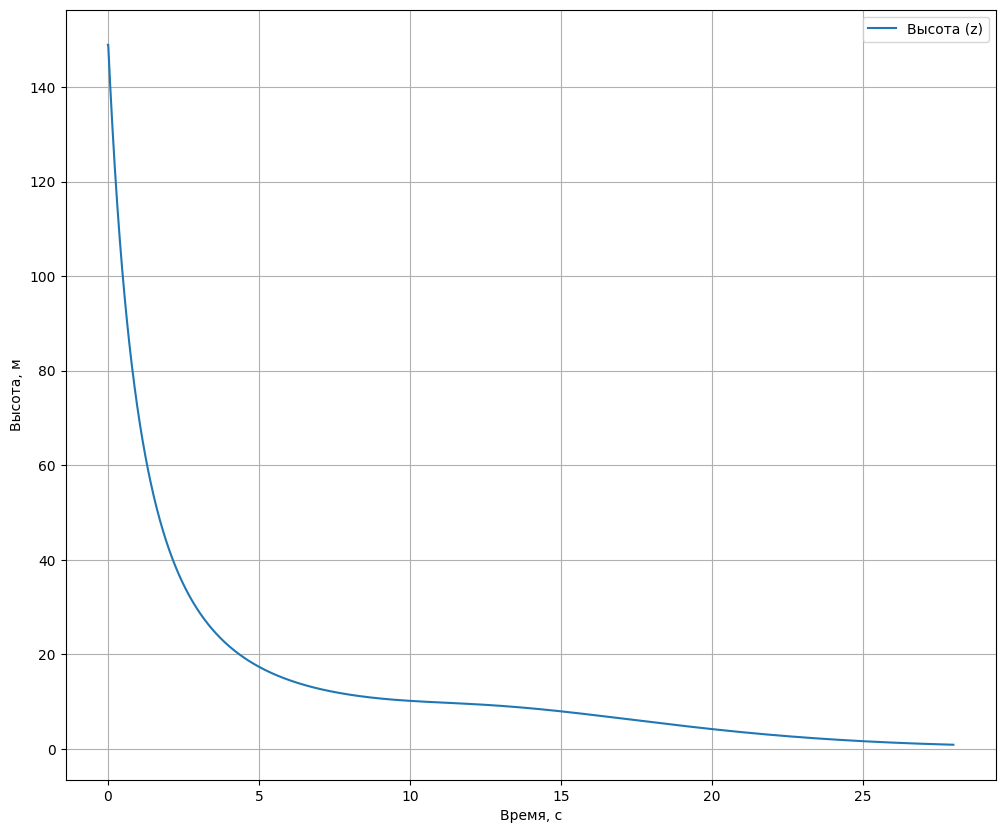

In [65]:
plt.figure(figsize=(12,10))
plt.plot(t, g_norm, label='Высота (z)') #g_traj_mzsk[:,0]
plt.xlabel('Время, с')
plt.ylabel('Высота, м')
#plt.ylim([0, 1200])
#plt.xlim([0, 30])
plt.grid()
plt.legend()
plt.show()